I will attempt to write a generalized SMC with a graph computation network

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
import tqdm

In [3]:
def polynomial_potential(x, hl):
    """
    define a polynomial potential of the form:
    hl[1,0]*(x - hl[0,0])**(len(hl[0,:])) + hl[1,1]*(x - hl[0,1])**(len(hl[0,:]) - 1) + ...
    
    arguments
        x : torch.tensor (shape: (1))
            position of particle
        hl : torch.tensor (shape: (2,N))
            'hyper' latent variables; the first row is a set of 'horizontal' offsets and the second row is a set of scaling coefficients;
            N is the highest polynomial power of the energy equation
    """
    #check that the shape is appropriate
    hl_size = hl.size()
    x_size = x.size()
    assert hl_size[0] == 2
    
    power_vector = torch.tensor(range(1, hl_size[1] + 1)[::-1])
    differences = x - hl[0,:]
    
    energy = (hl[1,:]*differences.pow(power_vector)).sum()
    
    return energy

def log_probability(potential):
    """
    generat a log unnormalized probability from a potential
    """
    return torch.exp(-potential)


In [4]:
def log_gaussian_probability(x, mu, sigma):
    """
    return log(N(x|mu, sigma))
    
    arguments
        x : torch.tensor (shape : (1))
            Lebesgue support
        mu : torch.tensor (shape : (1))
            mean
        sigma : torch.tensor (shape : (1))
            standard_deviation     
    returns
        logp : torch.tensor (shape : (1))
           log probability measure 
    """
    import math
    log_unnorm_prob = -(x - mu)**2 / (2 * sigma**2)  
    
    lognorm = torch.log(sigma * torch.sqrt(torch.tensor(2*math.pi)))
    
    logp = log_unnorm_prob - lognorm
    return logp
    
    

In [5]:
def gaussian_proposal(mu, sigma):
    """
    conduct a gaussian proposal (i.e. x ~ N(mu, sigma)); asserts that mu and sigma are requires_grad==False
    
    arguments
        mu : torch.tensor (shape : (1))
            mean
        sigma : torch.tensor (shape : (1))
            standard_deviation 
    returns
        x : torch.tensor(shape : (1), grad_)
            returnable position
    """
    x = sigma * torch.randn(1) + mu
    return x
    

In [6]:
def EL_mu_sigma(x, potential, tau):
    """
    create mu and sigma vars for the euler-maruyama proposal
    mu = x - tau * grad(potential)(x)
    """
    try:
        x.grad.zero_()
    except:
        pass
    potential.backward()
    mu = x - tau * x.grad
    sigma = torch.sqrt(2*tau)
    x.grad.zero_()
    return mu, sigma
    
    

In [7]:
#we should be able to propagate now... let's see if that works
x = torch.tensor(0., requires_grad=True)
hl = torch.tensor([[0., 0.], [1., 0.]], requires_grad=False)
energy = polynomial_potential(x, hl)

## Vanilla Brownian Motion on a Polynomial potential

In [8]:
def vanilla_polynomial_sampler(x, hl, tau, num_steps):
    """
    run simple, vanilla Euler Maruyama proposals on a constant pdf
    """
    import tqdm
    positions = []
    assert x.requires_grad
    for i in tqdm.trange(num_steps):
        energy = polynomial_potential(x, hl)
        mu, sigma = EL_mu_sigma(x, energy, tau)
        mu_batch, sigma_batch = mu.detach(), sigma.detach()
        x = gaussian_proposal(mu_batch, sigma_batch)
        positions.append(x.numpy())
        x.requires_grad=True
    
    out = np.array(positions).flatten()
    return out
        
        

In [9]:
x = torch.tensor(0., requires_grad=True)
hl = torch.tensor([[0., 0.], [1., 0.]], requires_grad=False)
tau = torch.tensor(5e-2)
out_pos = vanilla_polynomial_sampler(x, hl, tau, num_steps=1000)

100%|██████████| 1000/1000 [00:03<00:00, 323.73it/s]


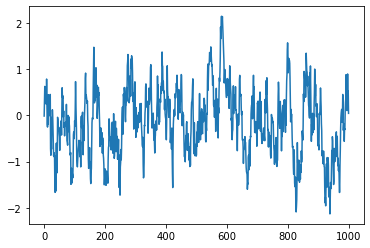

In [10]:
#plt.hist(out_pos)
plt.plot(out_pos)

## Annealed Importance Sampling between Gaussians

In the statistical literature, the geometric path for static models takes the form: $\gamma_t(dx) \equiv \mu (dx) \left( \frac{d \gamma}{d \mu}  (x)\right)^{\lambda_t}$ where $Z_t \equiv \gamma_t(\text{X})$ and $(\lambda_t)_{t \in [0:T]} \in [0,1]^{T+1}$.<br>
The Feynman-Kac path measure is recovered when we define potentials
$$
G_0(x_0) = 1 
\\
G_t(x_{t-1}) = \frac{\gamma_t(x_{t-1})}{\gamma_{t-1}(x_{t-1})}; t \in [1:T]
$$.
In this case, the normalizing constant $Z \equiv Z_T = \prod_{t=1}^{T} \left[ \frac{1}{N} \sum_{n=1}^N G_t(x_{t-1}^n) \right]$

For numerical stability, and for the sake of those who are restricted to thinking of things in terms of 'energy', we can say that $Z = \frac{1}{N} \sum_{n=1}^{N} \prod_{t=1}^{T} G_t(x_{t-1}^n)$ as long as particle ancestry is static. Interestingly, this is mathematically identical to the Jarzynski Equality, which says
$$
e^{-f} = \langle e^{-w} \rangle
$$
where $f = - \log Z$ and $w = -\log G_t(x_{t-1})$. <br>
Notice that we can also use the Crooks Fluctuation Theorem (CFT) (which implies the Jarzynski Equality), but it is worthy of mentioning that the CFT is just a specific case of the Feynman-Kac model (i.e. for static models). I will come back to this when I generalize Annealed Importance Sampling to the static model case.




For sanity purposes, I am going to plot the prior, the posterior, and a sequence of 98 intermediates...

In [11]:
def AIS(hl_prior, hl_posterior, num_particles, tau, num_target_distributions, starting_positions):
    """
    perform AIS with an euler-maruyama propagator on a polynomial potential with priors and posteriors defined accordingly; note, the propagator is not metropolized,
    so the target distributions are not exact, but should be close if tau is sufficiently small.
    
    arguments
        hl_prior : torch.tensor (shape: (2,N))
            the parameters defining the prior distribution
        hl_posterior : torch.tensor (shape: (2,N))
            the parameters defining the posterior distribution
        num_particles : int
            number of particles to propagate
        tau : torch.tensor (float)
            tau of euler-maruyama
        num_target_distributions : int
            number of target distributions (including prior and posterior)
        starting_positions : torch.tensor (shape: (1,N))
            starting positions of the propagator (assumed to be distributed according to the prior)
    
    returns
        positions : torch.tensor (shape: (1,N))
            final positions of the particles
        works : np.ndarray (shape (num_particles, num_target_distributions))
            array of incremental works of the particles
            take np.cumsum(works, axis=1) for array of cumulative works
        
    """
    works = np.zeros((num_particles, num_target_distributions)) #rows = num_particles, cols = num_target_distributions
    positions = starting_positions.clone().detach()
    
    #define a previous work tensor so that incremental works can be computed without having to recompute previous energy
    previous_energies = torch.tensor([polynomial_potential(q, hl_prior) for q in positions])
    
    #let's do this without presuming we can take grad and hardcode the whole process
    for lambda_idx, _lambda in enumerate(tqdm.tqdm(torch.tensor(np.linspace(0., 1., num_target_distributions)[1:]))):
        for particle_idx, x in enumerate(positions):
            #compute G_t
            x.requires_grad=True #so we can get force to propagate
            old_energy = polynomial_potential(x, hl_prior) #prior energy
            new_energy = polynomial_potential(x, hl_posterior) #posterior energy
            geometric_energy_increment = (1. - _lambda)*old_energy + _lambda * new_energy #hybrid_geometric_energy
            works[particle_idx, lambda_idx+1] = geometric_energy_increment - previous_energies[particle_idx] #compute incremental work
            previous_energies[particle_idx] = geometric_energy_increment #set the previous energy to the new updated work

            #propagate
            mu, sigma = EL_mu_sigma(x, new_energy, tau)
            mu_batch, sigma_batch = mu.detach(), sigma.detach()
            new_x = gaussian_proposal(mu_batch, sigma_batch)
            positions[particle_idx] = new_x
    
    return positions, works
    

Text(0, 0.5, '$p(x)$')

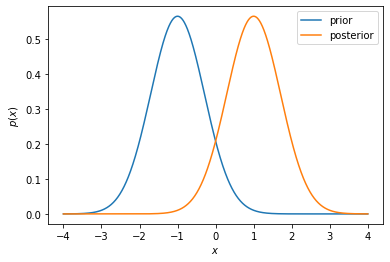

In [13]:
hl_prior = torch.tensor([[-1., 0.], [1., 0.]], requires_grad=False)
hl_posterior = torch.tensor([[1., 0.], [1., 0.]], requires_grad=False)
mu0, mu1 = torch.tensor(-1), torch.tensor(1)
sigma0, sigma1 = torch.tensor(1./np.sqrt(2)), torch.tensor(1./np.sqrt(2))
xs = np.linspace(-4, 4, 1000)
plt.plot(xs, [torch.exp(log_gaussian_probability(x, mu0, sigma0)) for x in torch.tensor(xs)], label = f"prior")
plt.plot(xs, [torch.exp(log_gaussian_probability(x, mu1, sigma1)) for x in torch.tensor(xs)], label = f"posterior")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$p(x)$")



In [17]:
num_particles = 50
starting_positions = torch.randn(num_particles)-1
positions, first_works = AIS(hl_prior, hl_posterior, num_particles=num_particles, tau=torch.tensor(5e-2), num_target_distributions=10, starting_positions = starting_positions)
first_cum_works = np.cumsum(first_works, axis=1)
first_final_weights = first_cum_works[:,-1]

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


In [18]:
positions, last_works = AIS(hl_prior, hl_posterior, num_particles=num_particles, tau=torch.tensor(5e-2), num_target_distributions=50, starting_positions = starting_positions)
final_cum_works = np.cumsum(last_works, axis=1)
final_final_weights = final_cum_works[:,-1]

100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


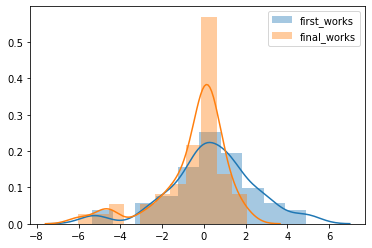

In [19]:
sns.distplot(first_final_weights, label = f"first_works")
sns.distplot(final_final_weights, label = f"final_works")
plt.legend()

So, it looks like we are able to recapitulate appropriate results (the free energy should be zero);<br>
we can also do this in the backward direction and use the maximum likelihood measure  (known as BAR), but i am not going to anneal in the backward directions since this seems to work rather well

The next thing I am going to do is write the generalized SMC algorithm (without resampling) with the _explicit_ $G_0$ and $G_t$ potential in terms of the Feynman-Kac model so that we can perhaps adapt it slightly and perform variational SMC on a static model.

A few notes on the following function:
- it should be clear at this point that we don't need to be able to take the derivative of any particle weights w.r.t. the particle position; the particle position is only `requires_grad=True` when it is explicitly invoked for a force computation (i.e. to conduct an Euler-Maruyama proposal)
- each $G_t$ potential, or incremental weight, should be appended to a list so that we _always_ have direct ability to manipulate the variable (if we modify a term)


In [20]:
def no_resample_generalized_smc(hls_target, hls_K, hls_L, num_particles, taus_L, taus_K, starting_positions):
    """
    in the interest of experimenting with the current capabilities of pytorchy computation graphs, i have a
    generalized smc method that _should_ be compatible with variational SMC, but does not resample.
    the reason i am doing this right now is that i want to be able to extend this bidirectionally and use an MLE estimator
    for the free energy, but it is not clear to me right now how to do that with resampling.
    
    Later, i will hopefully put this all together in a single pytorchy SMC class
    
    arguments
        hls_target : list(torch.tensor (shape: (2,target_i)))
            the parameters defining sequence of distributions and 
        hls_K : list(torch.tensor (shape: (2,hls_K_i)))
            the parameters defining the sequence of forward kernels
        hls_L : list(torch.tensor (shape: (2, hls_L_i)))
            the parameters defining the sequence of backward kernels        
        num_particles : int
            number of particles to propagate
        taus_L : list(torch.tensor (float))
            taus of euler-maruyama backward kernels
        taus_K : list(torch.tensor (float))
            taus of euler-maruyama forward kernels
        starting_positions : torch.tensor (shape: (1,N))
            starting positions of the propagator (assumed to be distributed according to the prior)
    
    returns
        positions : torch.tensor (shape: (1,N))
            final positions of the particles
        works : np.ndarray (shape (num_particles, num_target_distributions))
            array of incremental works of the particles
            take np.cumsum(works, axis=1) for array of cumulative works
    
    NOTE: every 'list' argument is required to be the same length; each entry are the parameters needed for \gamma_t, L_t
    """
    positions = starting_positions.clone().detach() #requires_grad=False, but we will re-enable in the propagation
    log_Gs = [] #initialize with an empty list
    
    #NOTE : for static models, \eta_0 and mu_0 (the pdfs of the first FK path measure and the Markov Chain Law initial pdf)
    #       are sampled from the same pdf, so the log G_0 = 0. (per usual)
    
    #this time, we'll just run the algorithm independently for each particle; maybe it will save time 
    for particle_idx in range(positions): #run the Markov Chain for each particle
        for t in range()
        position = positions[_idx]
        hl_L = hls_L[_idx]
        hl_K = hls_K[_idx]
        hl_gamma_old[]
        
        new_position, logG = SMC_iteration(position, hl_L, hl_K, hl_gamma_old, hl_gamma_new)
        
            
    

SyntaxError: unexpected EOF while parsing (<ipython-input-20-946afc61666f>, line 43)

In [21]:
def SMC_iteration(position, hl_L, hl_K, hl_gamma_old, hl_gamma_new):
    """
    conduct a single iteration of SMC for a single particle
    for static models, G_t = frac{\gamma_t(dx_t) L_{t-1}(x_t, dx_{t-1})}{\gamma_{t-1}(dx_{t-1}) K_t(x_{t-1}, dx_t)}
    
    arguments
        position : torch.tensor(float) (requires_grad=False)
            x_{t-1}
        hl_L : torch.tensor (shape : (2, N_L))
            parameters defining invariant target distribution for L_{t-1}
        hl_K : torch.tensor (shape : (2, N_K))
            parameters defining invariant target distribution for K_t
        hl_gamma : torch.tensor (shape : (2, N_gamma))
            parameters defining invariant target for \gamma_t
        tau_L : torch.tensor(float)
            tau of the backward kernel L_{t-1}
        tau_K : torch.tensor(float)
            tau of the forward kernel K_t
    
    returns
        logG_t : torch.tensor(float)
            log of the potential G_t (-work)
        position : torch.tensor(float) (requires_grad=False)
            new position after K_t propagation
    """
    #make a proposal with K_t from x_{t-1}
    old_position = position.clone().detach()
    old_position.requires_grad=True #make it 'derivitable w.r.t. potential'
    K_energy = polynomial_potential(old_position, hl_K)
    mu_K, sigma_K = EL_mu_sigma(old_position, K_energy, tau_K)
    new_position = gaussian_proposal(mu_K, sigma_K)
    
    #determine log_K
    log_K = log_gaussian_probability(new_position.clone().detach(), mu_K, sigma_K) #log_K is easy
    
    #determine log_L
    L_new_position = new_position.clone()
    L_energy = polynomial_potential(L_new_position)
    mu_L, sigma_L = EL_mu_sigma(L_new_position, L_energy, tau_L)
    log_L = log_gaussian_probability(position.clone().detach(), mu_L, sigma_L)
    
    #logG = log(\gamma_t(x_t)) + log(L_{t-1}(x_t, {dx_{t-1}})) - [ log(\gamma_{t-1}(x_{t-1})) + log(K_t(x_{t-1}, dx_t))  ]
    logG = (-polynomial_potential(new_position.clone().detach(), hl_gamma_new)
            + log_L
            - (-polynomial_potential(old_position.clone().detach(), hl_gamma_old)
               + log_K)
           )
    
    return new_position, logG   